In [1]:
!pip install wfdb
!pip install heartpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00 0:00:01


In [2]:
import os 
import wfdb
import numpy as np
import matplotlib.pyplot as plt

base_path = "/kaggle/input/mit-bih-sleep-apnea/mit-bih-polysomnographic-database-1.0.0/"

In [3]:
record = wfdb.rdrecord(os.path.join(base_path, 'slp01a'))

print("Signal names:", record.sig_name)
# print("Sampling rate:", record.fs)
# print("Signal shape (samples, channels):", record.p_signal.shape)

# ----------eeg signal---------------
eeg_signal = record.p_signal[:,2]
sampling_rate = record.fs
sampling_size_eeg = eeg_signal.shape[0]

print(f"Sampling rate of eeg signal:{sampling_rate}")
print(f"eeg_signal_shape: {eeg_signal.shape[0]}")
print (f"Total eeg signal length in second:{sampling_size_eeg/(250*3600)}hr")

# -------ecg signal -----------------

ecg_signal = record.p_signal[:,0]
sampling_rate_ecg = record.fs
sampling_size_ecg = ecg_signal.shape[0]

print(f"Sampling rate of ecg signal:{sampling_rate_ecg}")
print(f"eeg_signal_shape: {eeg_signal.shape[0]}")
print (f"Total ecg signal length in second:{sampling_size_ecg/(250*3600)}hr")


Signal names: ['ECG', 'BP', 'EEG (C4-A1)', 'Resp (sum)']
Sampling rate of eeg signal:250
eeg_signal_shape: 1800000
Total eeg signal length in second:2.0hr
Sampling rate of ecg signal:250
eeg_signal_shape: 1800000
Total ecg signal length in second:2.0hr


In [4]:
# Try opening the .st file in binary mode
base_path = '/kaggle/input/mit-bih-sleep-apnea/mit-bih-polysomnographic-database-1.0.0/'

sleep_stage = wfdb.rdann(os.path.join(base_path, 'slp01a'), 'st')

samples = sleep_stage.sample
labels = sleep_stage.aux_note

print(f"Total labels:{len(labels)}")

# Print first 20 sample points and labels
print("First 20 samples")
for i in range(20):
    time_sec = samples[i] / record.fs 
    print(f"Time(sec) {time_sec:.2f}, sleep/event label = {labels[i]}")

# print("Last 20 samples")
# for i in range(-20, 0):  # from 20th last to last
#     time_sec = samples[i] / record.fs  # sample index to seconds
#     print(f"Time (sec): {time_sec:.2f} - Label: {labels[i]}")

Total labels:240
First 20 samples
Time(sec) 0.00, sleep/event label = 4 LA LA
Time(sec) 30.00, sleep/event label = 4 LA
Time(sec) 60.00, sleep/event label = 4 LA
Time(sec) 90.00, sleep/event label = 4 L L L
Time(sec) 120.00, sleep/event label = 4 L
Time(sec) 150.00, sleep/event label = 4 L
Time(sec) 180.00, sleep/event label = 4 L L
Time(sec) 210.00, sleep/event label = 4 L
Time(sec) 240.00, sleep/event label = 4 L
Time(sec) 270.00, sleep/event label = 4 L L
Time(sec) 300.00, sleep/event label = 4 L L L
Time(sec) 330.00, sleep/event label = 4 LA
Time(sec) 360.00, sleep/event label = 3 HA
Time(sec) 390.00, sleep/event label = 3 H LA
Time(sec) 420.00, sleep/event label = 3 LA
Time(sec) 450.00, sleep/event label = 2 LA
Time(sec) 480.00, sleep/event label = 2 LA
Time(sec) 510.00, sleep/event label = 2 LA
Time(sec) 540.00, sleep/event label = 3 LA
Time(sec) 570.00, sleep/event label = 3 LA LA


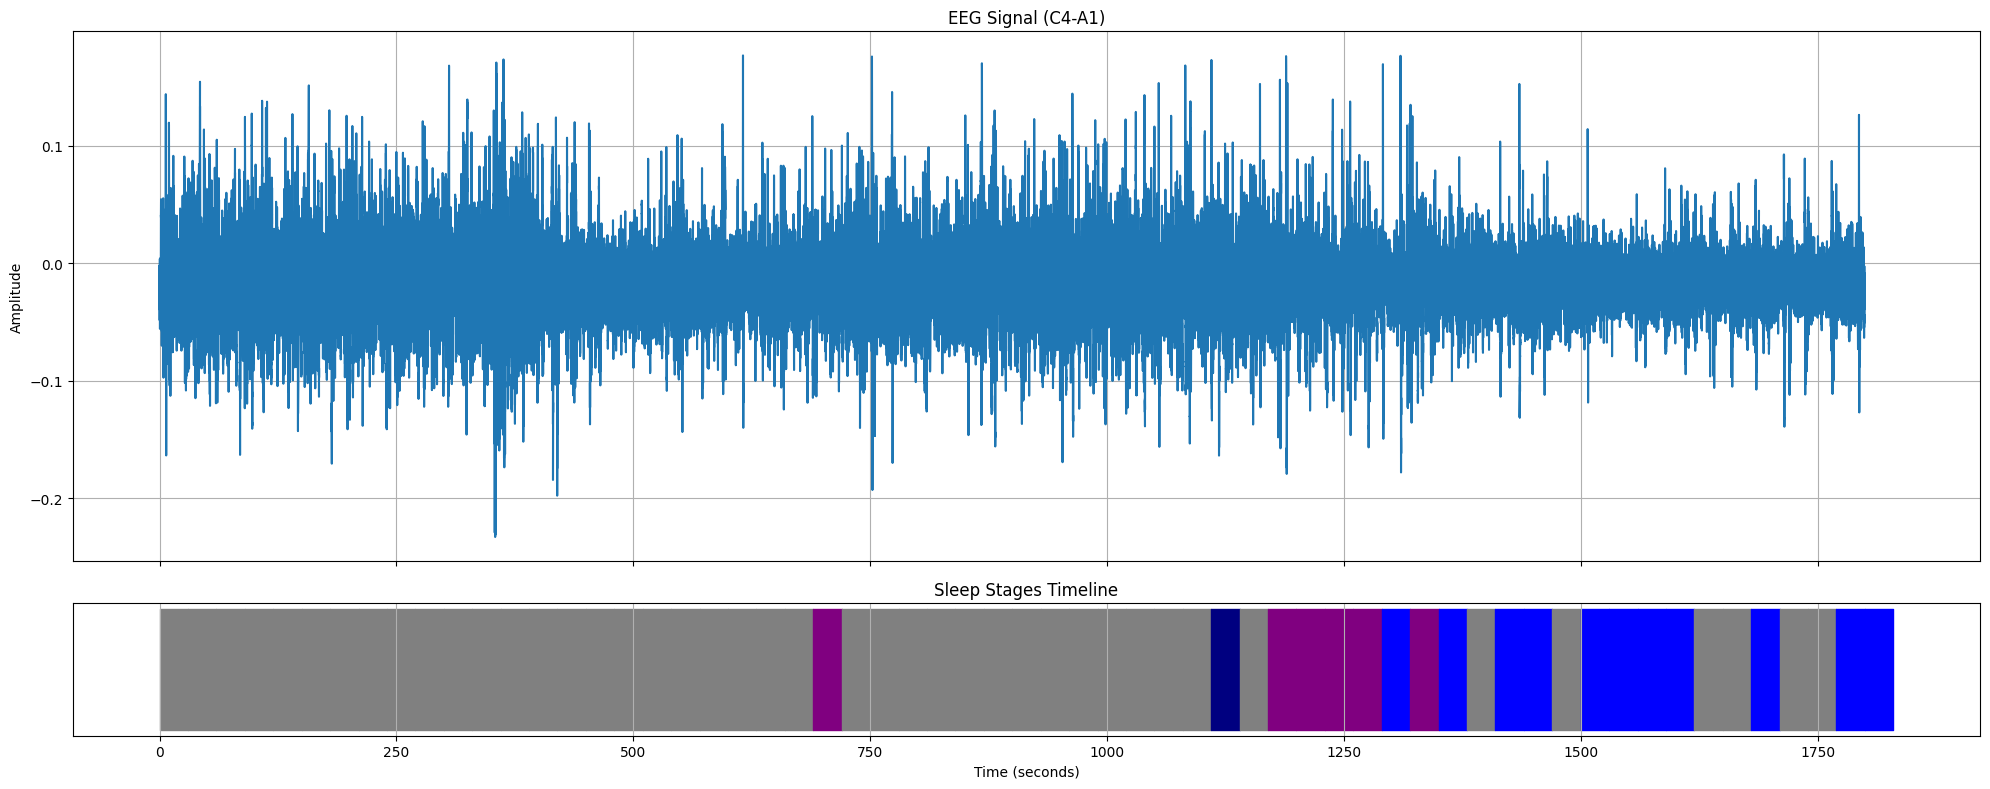

In [5]:
record = wfdb.rdrecord(os.path.join(base_path, 'slp01a'))
eeg_signal = record.p_signal[:, 2]  # EEG (C4-A1)

# Load the sleep stage annotations
sleep_stage = wfdb.rdann(os.path.join(base_path, 'slp01a'), 'st')
samples = sleep_stage.sample
labels = sleep_stage.aux_note
sampling_rate = record.fs  # usually 250 Hz


# ---stage colors------
stage_color = {
    'W': 'orange',   # Wake
    '1': 'lightblue',# Stage 1
    '2': 'blue',     # Stage 2
    '3': 'purple',   # Stage 3
    '4': 'navy',     # Stage 4
    'R': 'red',      # REM
    # Events like OA, HA, etc can be added if needed
}


# -------plotting------
# Prepare figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True, gridspec_kw={'height_ratios': [2, 0.5]})

# Create time axis for EEG
time_eeg = np.arange(eeg_signal.shape[0]) / sampling_rate

# Plot EEG signal
# To avoid a crazy-long plot, let's plot first 30 minutes only:
minutes_to_plot = 30
samples_to_plot = int(minutes_to_plot * 60 * sampling_rate)

ax1.plot(time_eeg[:samples_to_plot], eeg_signal[:samples_to_plot])
ax1.set_title('EEG Signal (C4-A1)')
ax1.set_ylabel('Amplitude')
ax1.grid()

# Plot Sleep Stages timeline
for i in range(len(labels) - 1):
    stage = labels[i].strip()  # remove any whitespace
    color = stage_color.get(stage, 'gray')  # default to gray if unknown label

    start_time = samples[i] / sampling_rate
    end_time = samples[i+1] / sampling_rate

    # Only plot within the 30 min window
    if start_time > minutes_to_plot * 60:
        break

    ax2.fill_betweenx([0, 1], start_time, end_time, color=color)

ax2.set_yticks([])
ax2.set_xlabel('Time (seconds)')
ax2.set_title('Sleep Stages Timeline')
ax2.grid()

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import wfdb
import os
import scipy.signal as signal
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import heartpy as hp


In [10]:
def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    ecg = record.p_signal[:, 0]  # Assuming ECG is first channel
    fs = record.fs
    return ecg, fs

def resample_ecg(ecg, orig_fs, target_fs=500):
    num_samples = int(len(ecg) * target_fs / orig_fs)
    resampled = signal.resample(ecg, num_samples)
    return resampled

def chebyshev_bandpass_filter(ecg, lowcut=0.5, highcut=100, fs=500):
    sos_low = signal.cheby2(2, 20, highcut, btype='low', fs=fs, output='sos')
    sos_high = signal.cheby2(2, 20, lowcut, btype='high', fs=fs, output='sos')
    ecg = signal.sosfiltfilt(sos_low, ecg)
    ecg = signal.sosfiltfilt(sos_high, ecg)
    return ecg

def detect_r_peaks(ecg, fs):
    diff = np.diff(ecg)
    squared = diff ** 2
    integrated = np.convolve(squared, np.ones(int(0.150*fs)), mode='same')
    peaks, _ = signal.find_peaks(integrated, distance=fs*0.6, height=np.mean(integrated))
    return peaks

def get_rr_intervals(peaks, fs):
    rr_intervals = np.diff(peaks) / fs
    return rr_intervals

def resample_rr(rr_intervals, target_fs=4):
    t_old = np.cumsum(np.insert(rr_intervals, 0, 0))
    t_new = np.arange(0, t_old[-1], 1/target_fs)
    interpolator = interp.interp1d(t_old, np.insert(rr_intervals, 0, rr_intervals[0]), kind='linear', fill_value="extrapolate")
    rr_resampled = interpolator(t_new)
    return rr_resampled

def detect_r_peaks_heartpy(ecg_signal, fs=500):
    working_data, measures = hp.process(ecg_signal, sample_rate=fs)
    r_peaks = working_data['peaklist']
    return np.array(r_peaks)


In [8]:
# Resample to 500 Hz
ecg_500 = resample_ecg(ecg, orig_fs=fs, target_fs=500)
# Apply Chebyshev bandpass filter
ecg_filt = chebyshev_bandpass_filter(ecg_500, fs=500)
# Detect R-peaks
# r_peaks = detect_r_peaks(ecg_filt, fs=500)
# r_peaks = detect_r_peaks_better(ecg_filt, fs=500)
r_peaks = detect_r_peaks_heartpy(ecg_filt, fs=500)
# Get RR intervals
rr_intervals = get_rr_intervals(r_peaks, fs=500)

# Resample RR to 4Hz
rr_4hz = resample_rr(rr_intervals, target_fs=4)


NameError: name 'ecg' is not defined

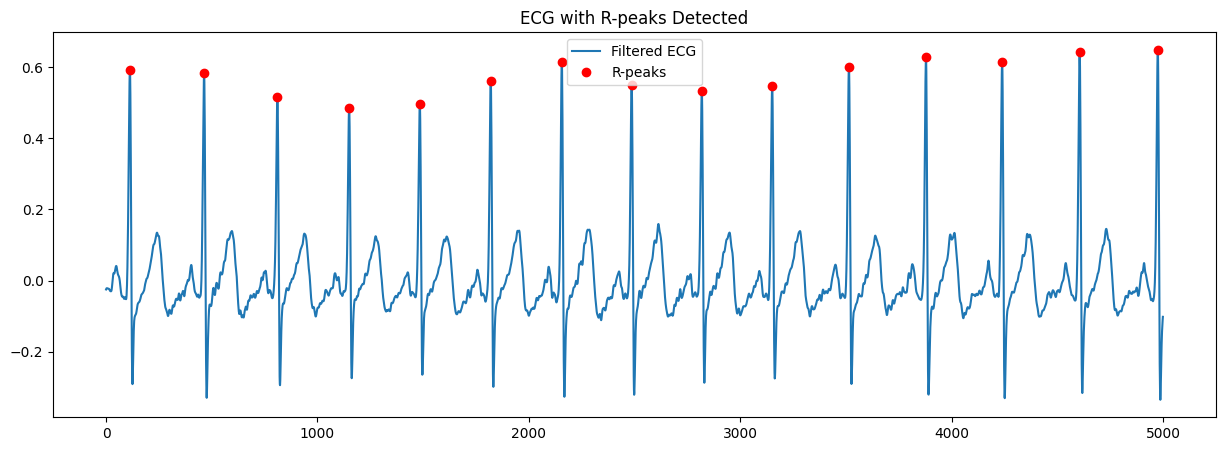

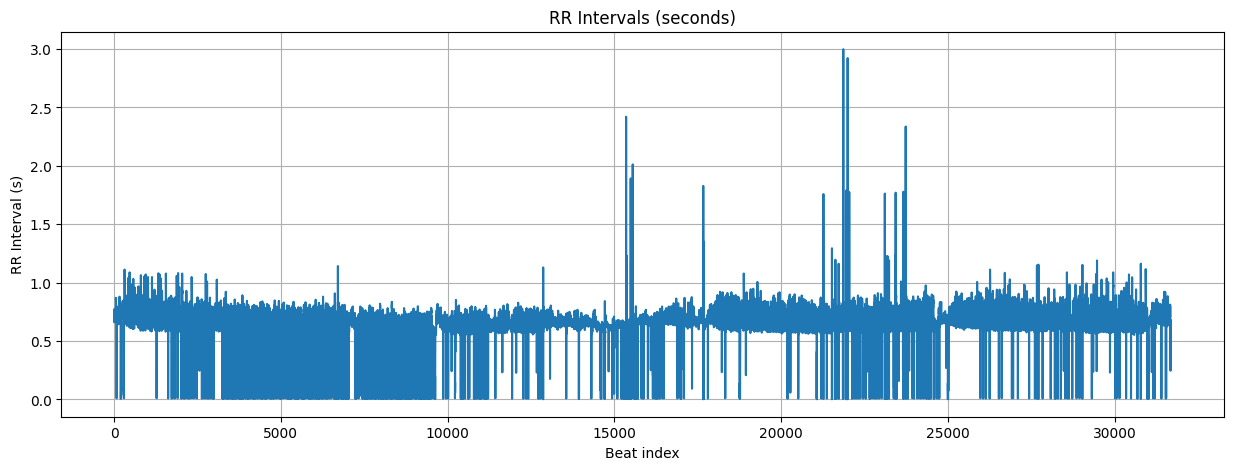

In [20]:
# Plot ECG + detected R-peaks
plt.figure(figsize=(15, 5))
plt.plot(ecg_filt[:5000], label='Filtered ECG')
plt.plot(r_peaks[r_peaks < 5000], ecg_filt[r_peaks[r_peaks < 5000]], 'ro', label='R-peaks')
plt.legend()
plt.title('ECG with R-peaks Detected')
plt.show()


# RR intervals 

plt.figure(figsize=(15,5))
plt.plot(rr_intervals)
plt.title("RR Intervals (seconds)")
plt.xlabel("Beat index")
plt.ylabel("RR Interval (s)")
plt.grid()
plt.show()


In [21]:
print(f"Number of R-peaks detected: {len(r_peaks)}")
print(f"First 10 R-peak indices: {r_peaks[:10]}")


Number of R-peaks detected: 31684
First 10 R-peak indices: [ 113  464  810 1150 1484 1820 2156 2486 2818 3151]


In [22]:
# Create Recurrence Plot from RR intervals
import numpy as np
import matplotlib.pyplot as plt
import cv2

def create_recurrence_plot(rr_signal, m=3, tau=2):
    N = len(rr_signal) - (m-1)*tau
    embedded = np.zeros((N, m))
    for i in range(m):
        embedded[:, i] = rr_signal[i*tau : i*tau+N]
    
    D = np.linalg.norm(embedded[:, None] - embedded[None, :], axis=2)
    D = (D - np.min(D)) / (np.max(D) - np.min(D))  # Normalize [0,1]
    return D

def save_rp_image(D, save_path):
    plt.figure(figsize=(2.27, 2.27), dpi=100)
    plt.imshow(D, cmap='jet')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def resize_image(img_path, target_size=(227, 227)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    cv2.imwrite(img_path, img)


In [23]:
import os
from tqdm import tqdm

# 1. Create folder to save recurrence plots
os.makedirs('/kaggle/working/rp_images', exist_ok=True)

# 2. Define helper function to check if RR window is good
def is_good_rr(rr_window, min_rr=0.3, max_rr=2.0, max_zero_ratio=0.05):
    # Conditions for bad window:
    # too many zero RR intervals or extremely abnormal values
    zero_count = np.sum(rr_window < min_rr)
    big_count = np.sum(rr_window > max_rr)
    if (zero_count + big_count) / len(rr_window) > max_zero_ratio:
        return False
    return True

# 3. Define constants
samples_per_minute = 4 * 60   # 4 Hz * 60 sec = 240 samples
num_minutes = len(rr_4hz) // samples_per_minute

print(f"Total 1-minute windows found: {num_minutes}")

# 4. Process each 1-min window
for minute_idx in tqdm(range(num_minutes)):
    start = minute_idx * samples_per_minute
    end = start + samples_per_minute

    rr_window = rr_4hz[start:end]

    if len(rr_window) == samples_per_minute:  # full minute
        if is_good_rr(rr_window):
            # Create Recurrence Plot
            D = create_recurrence_plot(rr_window)

            # Save Recurrence Plot
            save_path = f'/kaggle/working/rp_images/slp37_minute_{minute_idx:04d}.png'
            save_rp_image(D, save_path)
            resize_image(save_path)
        else:
            # Skipping bad window
            continue


Total 1-minute windows found: 349


100%|██████████| 349/349 [00:16<00:00, 20.85it/s]


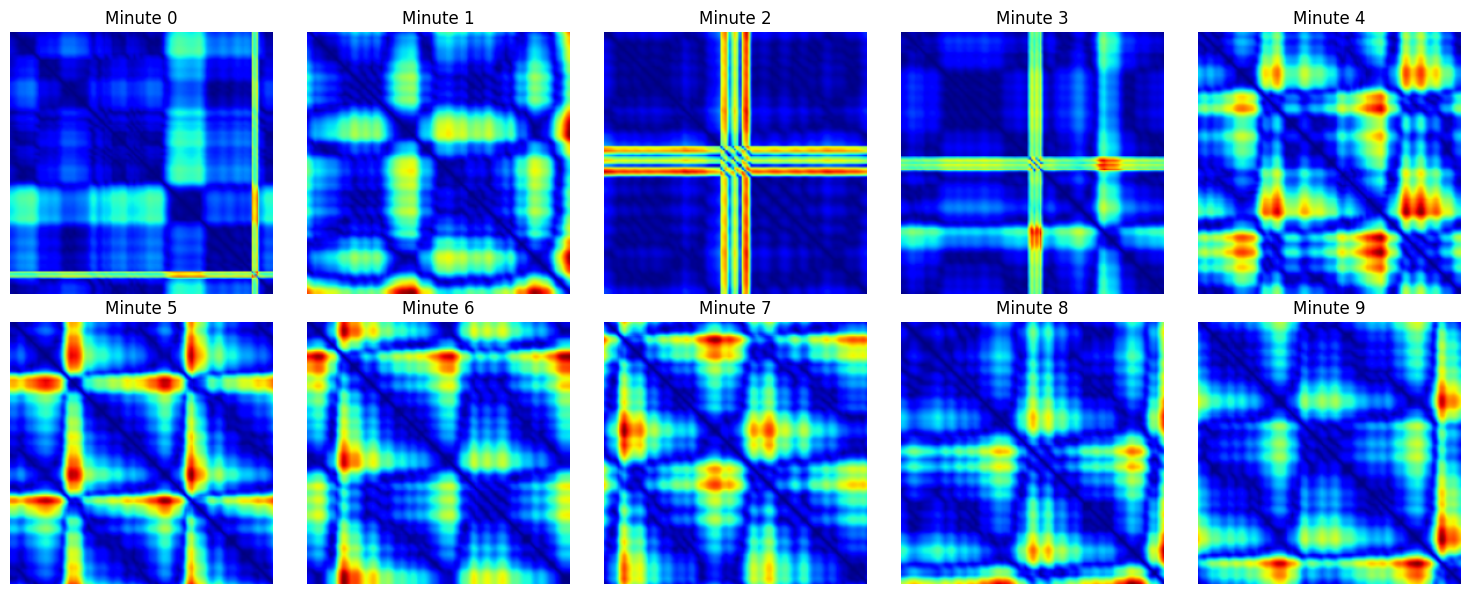

In [24]:
import matplotlib.pyplot as plt
import glob
import cv2

# Path to saved RP images
rp_folder = '/kaggle/working/rp_images/'

# Get list of image files
image_files = sorted(glob.glob(rp_folder + '*.png'))

# Plot first 10 images
num_images = 10
plt.figure(figsize=(15, 6))

for idx in range(num_images):
    img = cv2.imread(image_files[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(f"Minute {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


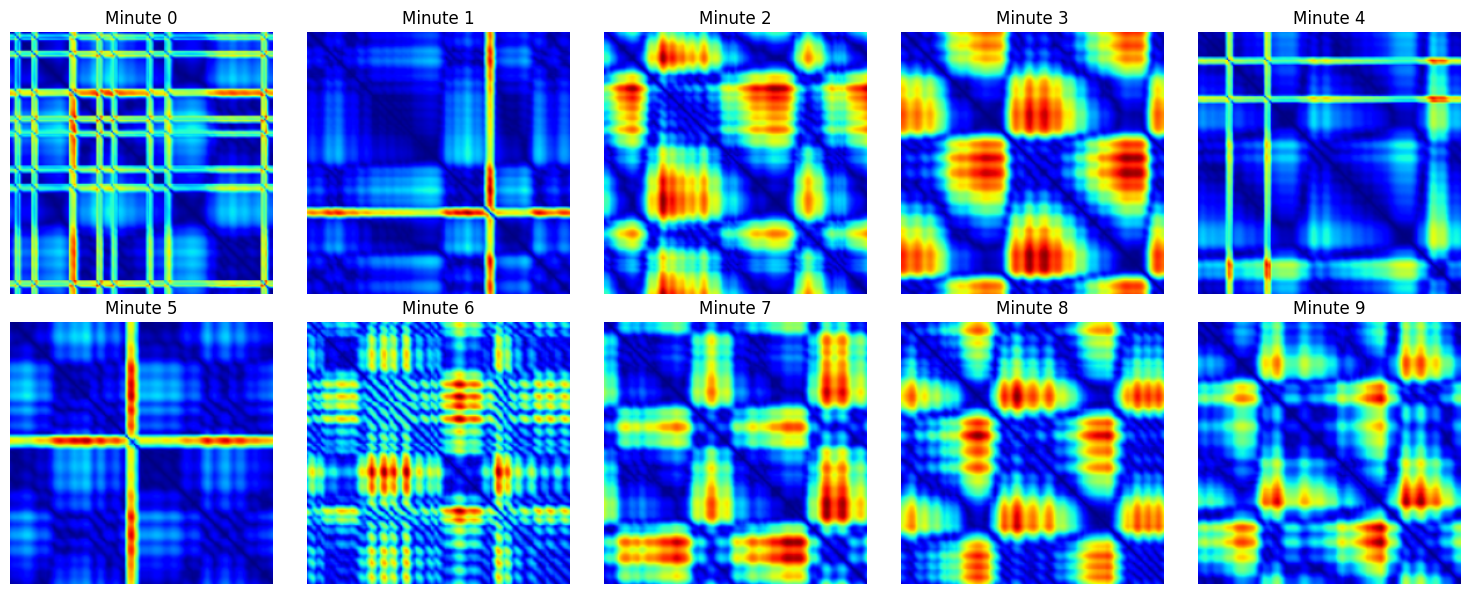

In [25]:
import random

rp_folder = '/kaggle/working/rp_images/'


# Get list of image files
image_files = sorted(glob.glob(rp_folder + '*.png'))
random.shuffle(image_files)
# Plot first 10 images
num_images = 10
plt.figure(figsize=(15, 6))

for idx in range(num_images):
    img = cv2.imread(image_files[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(f"Minute {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
print(f"Total duration based on RR resampled: {len(rr_4hz) / 4:.2f} seconds")
print(f"Total 1-minute windows: {len(rr_4hz) // 240}")


Total duration based on RR resampled: 20999.50 seconds
Total 1-minute windows: 349


In [27]:
import wfdb
import os
import glob

# Set path to dataset
base_path = '/kaggle/input/mit-bih-sleep-apnea/mit-bih-polysomnographic-database-1.0.0'

# Get list of all .hea files
hea_files = sorted(glob.glob(os.path.join(base_path, '*.hea')))
record_names = [os.path.basename(f).replace('.hea', '') for f in hea_files]

# Print durations
print(f"{'Record':<10} | {'Duration (min)':>15} | {'Duration (hr)':>15}")
print("-" * 45)

for name in record_names:
    try:
        record = wfdb.rdrecord(os.path.join(base_path, name))
        num_samples = record.sig_len
        fs = record.fs
        duration_min = num_samples / fs / 60
        print(f"{name:<10} | {duration_min:15.2f} | {duration_min/60:15.2f}")
    except Exception as e:
        print(f"{name:<10} | ERROR reading record: {e}")


Record     |  Duration (min) |   Duration (hr)
---------------------------------------------
slp01a     |          120.00 |            2.00
slp01b     |          180.00 |            3.00
slp02a     |          180.00 |            3.00
slp02b     |          135.00 |            2.25
slp03      |          360.00 |            6.00
slp04      |          360.00 |            6.00
slp14      |          360.00 |            6.00
slp16      |          360.00 |            6.00
slp32      |          320.00 |            5.33
slp37      |          350.00 |            5.83
slp41      |          390.00 |            6.50
slp45      |          380.00 |            6.33
slp48      |          380.00 |            6.33
slp59      |          240.00 |            4.00
slp60      |          355.00 |            5.92
slp61      |          370.00 |            6.17
slp66      |          220.00 |            3.67
slp67x     |           77.00 |            1.28


In [11]:
from scipy import signal, interpolate as interp
import heartpy as hp

def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    ecg = record.p_signal[:, 0]  # Assume ECG is first channel
    fs = record.fs
    return ecg, fs

def resample_ecg(ecg, orig_fs, target_fs=500):
    num_samples = int(len(ecg) * target_fs / orig_fs)
    return signal.resample(ecg, num_samples)

def chebyshev_bandpass_filter(ecg, lowcut=0.5, highcut=100, fs=500):
    sos_low = signal.cheby2(2, 20, highcut, btype='low', fs=fs, output='sos')
    sos_high = signal.cheby2(2, 20, lowcut, btype='high', fs=fs, output='sos')
    ecg = signal.sosfiltfilt(sos_low, ecg)
    ecg = signal.sosfiltfilt(sos_high, ecg)
    return ecg

def detect_r_peaks_heartpy(ecg_signal, fs=500):
    working_data, _ = hp.process(ecg_signal, sample_rate=fs)
    return np.array(working_data['peaklist'])

def get_rr_intervals(peaks, fs):
    return np.diff(peaks) / fs

def resample_rr(rr_intervals, target_fs=4):
    t_old = np.cumsum(np.insert(rr_intervals, 0, 0))
    t_new = np.arange(0, t_old[-1], 1 / target_fs)
    interpolator = interp.interp1d(t_old, np.insert(rr_intervals, 0, rr_intervals[0]),
                                   kind='linear', fill_value='extrapolate')
    return interpolator(t_new)

def is_good_rr(rr_window, min_rr=0.3, max_rr=2.0, max_bad_ratio=0.05):
    low_rr = np.sum(rr_window < min_rr)
    high_rr = np.sum(rr_window > max_rr)
    return (low_rr + high_rr) / len(rr_window) <= max_bad_ratio

def create_recurrence_plot(rr_signal, m=3, tau=2):
    """
    Convert RR signal into a recurrence plot (distance matrix).
    Output is a grayscale image (values 0–255).
    """
    N = len(rr_signal) - (m - 1) * tau
    if N <= 0:
        raise ValueError("RR signal too short for embedding.")

    embedded = np.zeros((N, m))
    for i in range(m):
        embedded[:, i] = rr_signal[i * tau : i * tau + N]

    # Compute pairwise distances
    D = np.linalg.norm(embedded[:, None] - embedded[None, :], axis=2)

    # Normalize to 0–255 grayscale
    D = (D - np.min(D)) / (np.max(D) - np.min(D) + 1e-8)
    return (D * 255).astype(np.uint8)


In [12]:
import os
import glob
import numpy as np
import pandas as pd
import warnings
import traceback
import time
from datetime import datetime
from tqdm import tqdm
import wfdb
import cv2

# Suppress heartpy spline warnings
warnings.filterwarnings("ignore", category=UserWarning, module='heartpy.analysis')

# === Config ===
target_ecg_fs = 500
target_rr_fs = 4
output_img_dir = '/kaggle/working/rp_images'
output_csv = '/kaggle/working/full_rp_labels.csv'
log_file = '/kaggle/working/rp_generation_log.txt'
base_path = '/kaggle/input/mit-bih-sleep-apnea/mit-bih-polysomnographic-database-1.0.0'

os.makedirs(output_img_dir, exist_ok=True)

# === Logging ===
def log(msg):
    print(msg, flush=True)
    with open(log_file, 'a') as f:
        f.write(f"{datetime.now()} - {msg}\n")

start_time = time.time()

# === Apnea Labeling Keywords ===
apnea_keywords = ['OA', 'HA', 'CA', 'X', 'CAA']
def is_apnea_label(note):
    return any(k in note for k in apnea_keywords)

# === ECG + RP processing helpers ===
def save_rp_image_opencv(D, save_path):
    img = (D * 255).astype(np.uint8)
    img = cv2.resize(img, (227, 227))
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    cv2.imwrite(save_path, img)

# You must define these functions before running the script:
# load_ecg(), resample_ecg(), chebyshev_bandpass_filter(),
# detect_r_peaks_heartpy(), get_rr_intervals(), resample_rr(),
# is_good_rr(), create_recurrence_plot()

# === Main Loop ===
all_filenames = []
all_labels = []
record_paths = sorted(glob.glob(os.path.join(base_path, '*.hea')))
record_names = [os.path.basename(p).replace('.hea', '') for p in record_paths]

log(f"Processing {len(record_names)} records...")

for record_name in tqdm(record_names):
    record_start = time.time()
    try:
        ecg, fs = load_ecg(os.path.join(base_path, record_name))
        ecg_500 = resample_ecg(ecg, fs, target_ecg_fs)
        ecg_filt = chebyshev_bandpass_filter(ecg_500, fs=target_ecg_fs)

        try:
            r_peaks = detect_r_peaks_heartpy(ecg_filt, fs=target_ecg_fs)
        except Exception as e:
            log(f"HeartPy failed for {record_name}: {e}")
            continue

        rr_intervals = get_rr_intervals(r_peaks, fs=target_ecg_fs)
        rr_4hz = resample_rr(rr_intervals, target_fs=target_rr_fs)

        ann = wfdb.rdann(os.path.join(base_path, record_name), 'st')
        aux_notes = ann.aux_note
        sample_times = np.array(ann.sample) / ann.fs

        samples_per_min = target_rr_fs * 60
        num_windows = len(rr_4hz) // samples_per_min

        for i in range(num_windows):
            start = i * samples_per_min
            end = start + samples_per_min
            rr_window = rr_4hz[start:end]

            if len(rr_window) != samples_per_min or not is_good_rr(rr_window):
                continue

            D = create_recurrence_plot(rr_window)
            fname = f"{record_name}_min{i:04d}.png"
            save_path = os.path.join(output_img_dir, fname)
            save_rp_image_opencv(D, save_path)

            start_sec = start / target_rr_fs
            end_sec = end / target_rr_fs
            label = 0
            for j in range(len(sample_times)):
                if start_sec <= sample_times[j] < end_sec:
                    if is_apnea_label(aux_notes[j]):
                        label = 1
                        break

            all_filenames.append(fname)
            all_labels.append(label)

            if i % 50 == 0:
                log(f"...{record_name}: processed window {i}/{num_windows}")

        elapsed = time.time() - record_start
        log(f"✅ Finished {record_name} in {elapsed:.2f}s with {num_windows} windows")

    except Exception as e:
        log(f"❌ Error in {record_name}: {e}")
        traceback.print_exc(file=open(log_file, 'a'))
        continue

# === Save labels CSV ===
df = pd.DataFrame({'filename': all_filenames, 'label': all_labels})
df.to_csv(output_csv, index=False)

end_time = time.time()
log(f"\n✅ Saved dataset: {output_csv}")
log(f"Total records processed: {len(record_names)}")
log(f"Total RP images saved: {len(all_filenames)}")
log(f"Total runtime: {(end_time - start_time)/60:.2f} minutes")


Processing 18 records...


  0%|          | 0/18 [00:00<?, ?it/s]

...slp01a: processed window 0/119
...slp01a: processed window 50/119
...slp01a: processed window 100/119
✅ Finished slp01a in 8.94s with 119 windows


  6%|▌         | 1/18 [00:08<02:31,  8.94s/it]

...slp01b: processed window 0/179
...slp01b: processed window 50/179
...slp01b: processed window 100/179
...slp01b: processed window 150/179
✅ Finished slp01b in 25.94s with 179 windows


 11%|█         | 2/18 [00:34<05:03, 18.94s/it]

...slp02a: processed window 0/179
...slp02a: processed window 50/179
...slp02a: processed window 100/179
...slp02a: processed window 150/179
✅ Finished slp02a in 9.94s with 179 windows


 17%|█▋        | 3/18 [00:44<03:42, 14.83s/it]

...slp02b: processed window 0/134
...slp02b: processed window 50/134
...slp02b: processed window 100/134
✅ Finished slp02b in 22.19s with 134 windows


 22%|██▏       | 4/18 [01:07<04:08, 17.74s/it]

✅ Finished slp03 in 10.36s with 359 windows


 28%|██▊       | 5/18 [01:17<03:16, 15.08s/it]

✅ Finished slp04 in 2111.73s with 359 windows


 33%|███▎      | 6/18 [36:29<2:25:35, 727.94s/it]

...slp14: processed window 0/359
...slp14: processed window 50/359
...slp14: processed window 100/359
...slp14: processed window 150/359
...slp14: processed window 200/359
...slp14: processed window 250/359
...slp14: processed window 300/359
...slp14: processed window 350/359
✅ Finished slp14 in 90.41s with 359 windows


 39%|███▉      | 7/18 [37:59<1:35:14, 519.52s/it]

...slp16: processed window 0/359
...slp16: processed window 50/359
...slp16: processed window 100/359
...slp16: processed window 150/359
...slp16: processed window 200/359
...slp16: processed window 250/359
...slp16: processed window 300/359
...slp16: processed window 350/359
✅ Finished slp16 in 108.95s with 359 windows


 44%|████▍     | 8/18 [39:48<1:04:48, 388.81s/it]

...slp32: processed window 0/319
...slp32: processed window 50/319
...slp32: processed window 100/319
...slp32: processed window 150/319
...slp32: processed window 200/319
...slp32: processed window 250/319
...slp32: processed window 300/319
✅ Finished slp32 in 62.37s with 319 windows


 50%|█████     | 9/18 [40:50<43:00, 286.76s/it]  

...slp37: processed window 0/349
...slp37: processed window 50/349
...slp37: processed window 150/349
...slp37: processed window 200/349
...slp37: processed window 250/349
...slp37: processed window 300/349
✅ Finished slp37 in 114.61s with 349 windows


 56%|█████▌    | 10/18 [42:45<31:08, 233.62s/it]

...slp41: processed window 50/389
...slp41: processed window 100/389
...slp41: processed window 150/389
...slp41: processed window 200/389
...slp41: processed window 250/389
...slp41: processed window 300/389
...slp41: processed window 350/389
✅ Finished slp41 in 78.58s with 389 windows


 61%|██████    | 11/18 [44:04<21:43, 186.17s/it]

...slp45: processed window 50/379
...slp45: processed window 100/379
...slp45: processed window 150/379
...slp45: processed window 200/379
...slp45: processed window 250/379
...slp45: processed window 300/379
...slp45: processed window 350/379
✅ Finished slp45 in 110.06s with 379 windows


 67%|██████▋   | 12/18 [45:54<16:18, 163.02s/it]

...slp48: processed window 0/379
...slp48: processed window 50/379
...slp48: processed window 100/379
...slp48: processed window 150/379
...slp48: processed window 200/379
...slp48: processed window 250/379
...slp48: processed window 300/379
...slp48: processed window 350/379
✅ Finished slp48 in 81.13s with 379 windows


 72%|███████▏  | 13/18 [47:15<11:31, 138.21s/it]

...slp59: processed window 0/239
...slp59: processed window 50/239
...slp59: processed window 100/239
...slp59: processed window 150/239
...slp59: processed window 200/239
✅ Finished slp59 in 41.05s with 239 windows


 78%|███████▊  | 14/18 [47:56<07:15, 108.86s/it]

✅ Finished slp60 in 128.17s with 354 windows


 83%|████████▎ | 15/18 [50:04<05:44, 114.68s/it]

...slp61: processed window 0/369
...slp61: processed window 50/369
...slp61: processed window 100/369
...slp61: processed window 150/369
...slp61: processed window 200/369
...slp61: processed window 250/369
...slp61: processed window 300/369
...slp61: processed window 350/369
✅ Finished slp61 in 97.77s with 369 windows


 89%|████████▉ | 16/18 [51:42<03:39, 109.59s/it]

...slp66: processed window 0/219
...slp66: processed window 50/219
...slp66: processed window 100/219
...slp66: processed window 150/219
...slp66: processed window 200/219
✅ Finished slp66 in 38.00s with 219 windows


 94%|█████████▍| 17/18 [52:20<01:28, 88.07s/it] 

...slp67x: processed window 0/76
...slp67x: processed window 50/76
✅ Finished slp67x in 5.66s with 76 windows


100%|██████████| 18/18 [52:25<00:00, 174.77s/it]


✅ Saved dataset: /kaggle/working/full_rp_labels.csv
Total records processed: 18
Total RP images saved: 3938
Total runtime: 52.43 minutes


In [13]:
# -----Dataset Class-----------


import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

class RPDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.data.iloc[idx]['label'])
        if self.transform:
            image = self.transform(image)
        return image, label


In [22]:
import torch.nn as nn
import torch.nn.functional as F

class ApneaCNN_Small(nn.Module):
    def __init__(self):
        super(ApneaCNN_Small, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)    # [B, 16, 227, 227]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)   # [B, 32, 114, 114]
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # [B, 64, 57, 57]

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(0.3)

        self.fc1 = nn.Linear(28 * 28 * 64, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))      # -> [B, 16, 114, 114]
        x = self.pool(F.relu(self.conv2(x)))      # -> [B, 32, 57, 57]
        x = self.pool(F.relu(self.conv3(x)))      # -> [B, 64, 28, 28]
        x = self.dropout_conv(x)

        x = x.view(-1, 28 * 28 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [23]:
from torchvision import models
import torch.nn as nn

# Load pretrained model
model = models.resnet18(pretrained=True)

# Freeze early layers (optional but helpful)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)  # 2 classes
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s] 


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/kaggle/working/full_rp_labels.csv')
# Split 80% train, 10% val, 10% test
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.111, stratify=train_val_df['label'], random_state=42)


train_df.to_csv('/kaggle/working/train_labels.csv', index=False)
val_df.to_csv('/kaggle/working/val_labels.csv', index=False)
test_df.to_csv('/kaggle/working/test_labels.csv', index=False)


print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Label distribution in Train:\n", train_df['label'].value_counts())
print("Label distribution in Val:\n", val_df['label'].value_counts())
print("Label distribution in Test:\n", test_df['label'].value_counts())


Train: 3150 Val: 394 Test: 394
Label distribution in Train:
 label
0    1972
1    1178
Name: count, dtype: int64
Label distribution in Val:
 label
0    247
1    147
Name: count, dtype: int64
Label distribution in Test:
 label
0    247
1    147
Name: count, dtype: int64


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ApneaCNN_Small().to(device)


In [27]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os

# Custom dataset
class RPImageDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = RPImageDataset('/kaggle/working/train_labels.csv', '/kaggle/working/rp_images', transform)
val_dataset = RPImageDataset('/kaggle/working/val_labels.csv', '/kaggle/working/rp_images', transform)

# # Dataloaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [29]:
from torchvision import transforms

# train_transform = transforms.Compose([
#     transforms.Resize((227, 227)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor()
# ])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])


train_dataset = RPImageDataset('train_labels.csv', 'rp_images', transform=train_transform)
val_dataset = RPImageDataset('val_labels.csv', 'rp_images', transform=val_transform)


In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss with weights
criterion = nn.CrossEntropyLoss(weight=weights)


# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dataset):.4f}, Train Acc: {acc:.4f}")

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_dataset)
    print(f"Validation Acc: {val_acc:.4f}")


NameError: name 'train_loader' is not defined

In [32]:
df = pd.read_csv('/kaggle/working/full_rp_labels.csv')
print(df['label'].value_counts())


label
0    2466
1    1472
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.5871, Train Acc: 0.6924
Validation Acc: 0.7107
✅ Saved new best model (val acc = 0.7107)
Epoch 2, Loss: 0.5164, Train Acc: 0.7578
Validation Acc: 0.7386
✅ Saved new best model (val acc = 0.7386)
Epoch 3, Loss: 0.4650, Train Acc: 0.7921
Validation Acc: 0.7157
Epoch 4, Loss: 0.4253, Train Acc: 0.8143
Validation Acc: 0.7360
Epoch 5, Loss: 0.3899, Train Acc: 0.8321
Validation Acc: 0.7766
✅ Saved new best model (val acc = 0.7766)
Epoch 6, Loss: 0.3357, Train Acc: 0.8654
Validation Acc: 0.7614
Epoch 7, Loss: 0.2956, Train Acc: 0.8727
Validation Acc: 0.7766
Epoch 8, Loss: 0.2729, Train Acc: 0.8908
Validation Acc: 0.7766
Epoch 9, Loss: 0.2409, Train Acc: 0.9054
Validation Acc: 0.7386
Epoch 10, Loss: 0.2122, Train Acc: 0.9187
Validation Acc: 0.7766
Epoch 11, Loss: 0.1871, Train Acc: 0.9321
Validation Acc: 0.7360
Epoch 12, Loss: 0.1553, Train Acc: 0.9438
Validation Acc: 0.7310
Epoch 13, Loss: 0.1497, Train Acc: 0.9406
Validation Acc: 0.7538
Epoch 14, Loss: 0.1512, Train Acc: 0.9

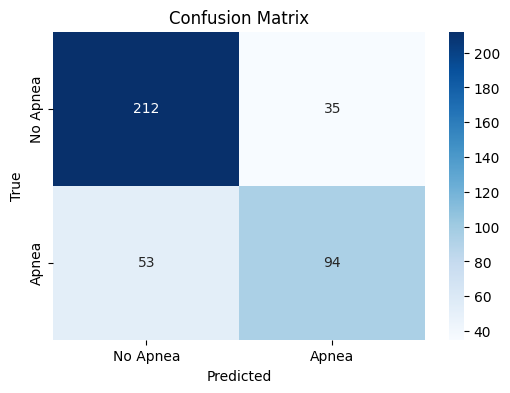

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# === Custom Dataset ===
class RPImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, int(label)

# === Transforms ===
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# === Load Data ===
img_dir = '/kaggle/working/rp_images'
train_ds = RPImageDataset('/kaggle/working/train_labels.csv', img_dir, transform=train_transform)
val_ds = RPImageDataset('/kaggle/working/val_labels.csv', img_dir, transform=val_transform)
test_ds = RPImageDataset('/kaggle/working/test_labels.csv', img_dir, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# === Class Weights ===
df = pd.read_csv('/kaggle/working/full_rp_labels.csv')
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0,1], y=df['label'])
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# === Model: ResNet18 ===
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all

# Unfreeze last layer
for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)
model = model.to(device)

# === Optimizer, Loss, Scheduler ===
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# === Training Loop ===
best_val_acc = 0

for epoch in range(15):
    model.train()
    train_loss, correct = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    scheduler.step()

    train_acc = correct / len(train_ds)
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_ds):.4f}, Train Acc: {train_acc:.4f}")

    # === Validation ===
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_ds)
    print(f"Validation Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
        print(f"✅ Saved new best model (val acc = {val_acc:.4f})")

# === Test Set Evaluation ===
model.load_state_dict(torch.load('/kaggle/working/best_model.pt', weights_only=True))

model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# === Metrics ===
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Apnea', 'Apnea'], yticklabels=['No Apnea', 'Apnea'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [12]:
from scipy.signal import spectrogram
import os
import glob
import numpy as np
import pandas as pd
import warnings
import traceback
import time
from datetime import datetime
from tqdm import tqdm
import wfdb
import cv2

In [7]:
# === Paths ===
base_path = '/kaggle/input/mit-bih-sleep-apnea/mit-bih-polysomnographic-database-1.0.0'
output_dir = '/kaggle/working/eeg_spectrograms'
output_csv = '/kaggle/working/eeg_labels.csv'
os.makedirs(output_dir, exist_ok=True)

# === Annotation Keywords for Apnea ===
apnea_keywords = ['OA', 'HA', 'CA', 'X', 'CAA']


In [9]:
# === Helper: Save EEG Spectrogram ===
def save_eeg_spectrogram(signal, fs, save_path):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128)
    Sxx_log = 10 * np.log10(Sxx + 1e-10)
    plt.figure(figsize=(2.27, 2.27), dpi=100)
    plt.pcolormesh(t, f, Sxx_log, shading='gouraud', cmap='viridis')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [10]:
def build_stage_vector(ann, signal_len):
    stage_vector = [''] * signal_len
    last_valid_stage = ''

    for i in range(len(ann.sample) - 1):
        start = ann.sample[i]
        end = ann.sample[i + 1]

        clean_note = ann.aux_note[i].replace('"', '').strip()
        tokens = clean_note.split()
        first_token = tokens[0] if tokens else ''

        if first_token in ['W', '1', '2', '3', '4', 'R']:
            last_valid_stage = first_token

        for j in range(start, min(end, signal_len)):
            stage_vector[j] = last_valid_stage

    # Handle the tail
    clean_note = ann.aux_note[-1].replace('"', '').strip()
    tokens = clean_note.split()
    first_token = tokens[0] if tokens else ''
    if first_token in ['W', '1', '2', '3', '4', 'R']:
        last_valid_stage = first_token
    for j in range(ann.sample[-1], signal_len):
        stage_vector[j] = last_valid_stage

    return stage_vector


In [13]:
# === Processing Loop for 30-second EEG windows ===
all_filenames = []
all_labels = []
all_stages = []

record_files = sorted([f for f in os.listdir(base_path) if f.endswith('.hea')])
for rec_file in tqdm(record_files):
    record_name = rec_file.replace('.hea', '')
    try:
        record = wfdb.rdrecord(os.path.join(base_path, record_name))
        fs = record.fs
        sig_names = record.sig_name
        if "EEG (C4-A1)" not in sig_names:
            print(f"⚠️ Skipping {record_name}: EEG channel not found")
            continue
        eeg_idx = sig_names.index("EEG (C4-A1)")
        eeg = record.p_signal[:, eeg_idx]

        # Load annotations
        ann = wfdb.rdann(os.path.join(base_path, record_name), 'st')

        # === Debug: Print first few annotation notes ===
        print(f"\n[ANNOTATIONS for {record_name}]")
        for s, note in zip(ann.sample[:10], ann.aux_note[:10]):
            clean_note = note.replace('"', '')
            print(f"Sample: {s}, Note: {note} -> Clean: {clean_note}")

        sample_times = np.array(ann.sample) / fs
        aux_notes = ann.aux_note
        stage_vector = build_stage_vector(ann, len(eeg))

        # Slice into 30-second windows
        samples_per_win = fs * 30
        num_windows = len(eeg) // samples_per_win

        print(f"[INFO] Processing {record_name} with {num_windows} 30-sec windows")

        for i in range(num_windows):
            start = i * samples_per_win
            end = start + samples_per_win
            eeg_win = eeg[start:end]
            if len(eeg_win) != samples_per_win:
                continue

            # Label apnea presence
            start_sec = start / fs
            end_sec = end / fs
            label = 0
            for j in range(len(sample_times)):
                if start_sec <= sample_times[j] < end_sec:
                    if any(k in aux_notes[j] for k in apnea_keywords):
                        label = 1
                        break

            # Sleep Stage (safe extraction)
            window_stages = stage_vector[start:end]
            if window_stages:
                non_empty = [s for s in window_stages if s != '']
                stage = max(set(non_empty), key=non_empty.count) if non_empty else ''
            else:
                stage = ''

            # Debug if stage missing
            if stage == '' and label == 1:
                print(f"[DEBUG] Apnea window missing stage: {record_name} win {i}")

            # Save spectrogram
            fname = f"{record_name}_win{i:04d}.png"
            save_path = os.path.join(output_dir, fname)
            save_eeg_spectrogram(eeg_win, fs, save_path)

            # Record row
            all_filenames.append(fname)
            all_labels.append(label)
            all_stages.append(stage)

    except Exception as e:
        print(f"❌ Error processing {record_name}: {e}")
        continue

# === Save Final DataFrame ===
df = pd.DataFrame({
    'filename': all_filenames,
    'label': all_labels,
    'stage': all_stages
})
df.to_csv(output_csv, index=False)
print(f"\n✅ Saved {len(df)} labeled EEG windows to {output_csv}")


  0%|          | 0/18 [00:00<?, ?it/s]


[ANNOTATIONS for slp01a]
Sample: 1, Note: 4 LA LA -> Clean: 4 LA LA
Sample: 7500, Note: 4 LA -> Clean: 4 LA
Sample: 15000, Note: 4 LA -> Clean: 4 LA
Sample: 22500, Note: 4 L L L -> Clean: 4 L L L
Sample: 30000, Note: 4 L -> Clean: 4 L
Sample: 37500, Note: 4 L -> Clean: 4 L
Sample: 45000, Note: 4 L L -> Clean: 4 L L
Sample: 52500, Note: 4 L -> Clean: 4 L
Sample: 60000, Note: 4 L -> Clean: 4 L
Sample: 67500, Note: 4 L L -> Clean: 4 L L
[INFO] Processing slp01a with 240 30-sec windows


  6%|▌         | 1/18 [00:26<07:23, 26.10s/it]


[ANNOTATIONS for slp01b]
Sample: 1, Note: 2 -> Clean: 2
Sample: 7500, Note: 2 -> Clean: 2
Sample: 15000, Note: 2 -> Clean: 2
Sample: 22500, Note: 2 -> Clean: 2
Sample: 30000, Note: 2 -> Clean: 2
Sample: 37500, Note: 2 -> Clean: 2
Sample: 45000, Note: 2 -> Clean: 2
Sample: 52500, Note: 2 -> Clean: 2
Sample: 60000, Note: 2 -> Clean: 2
Sample: 67500, Note: W -> Clean: W
[INFO] Processing slp01b with 360 30-sec windows


 17%|█▋        | 3/18 [01:05<04:38, 18.58s/it]

⚠️ Skipping slp02a: EEG channel not found


 22%|██▏       | 4/18 [01:06<02:39, 11.37s/it]

⚠️ Skipping slp02b: EEG channel not found


 28%|██▊       | 5/18 [01:06<01:37,  7.54s/it]

⚠️ Skipping slp03: EEG channel not found


 33%|███▎      | 6/18 [01:07<01:02,  5.24s/it]

⚠️ Skipping slp04: EEG channel not found


 39%|███▉      | 7/18 [01:08<00:41,  3.75s/it]

⚠️ Skipping slp14: EEG channel not found


 44%|████▍     | 8/18 [01:09<00:28,  2.85s/it]

⚠️ Skipping slp16: EEG channel not found

[ANNOTATIONS for slp32]
Sample: 1, Note: W -> Clean: W
Sample: 7500, Note: W -> Clean: W
Sample: 15000, Note: W -> Clean: W
Sample: 22500, Note: W -> Clean: W
Sample: 30000, Note: W -> Clean: W
Sample: 37500, Note: W -> Clean: W
Sample: 45000, Note: W -> Clean: W
Sample: 52500, Note: W -> Clean: W
Sample: 60000, Note: W -> Clean: W
Sample: 67500, Note: W -> Clean: W
[INFO] Processing slp32 with 640 30-sec windows


 50%|█████     | 9/18 [02:20<03:36, 24.10s/it]


[ANNOTATIONS for slp37]
Sample: 15000, Note: W -> Clean: W
Sample: 22500, Note: 1 OA -> Clean: 1 OA
Sample: 30000, Note: 1 OA -> Clean: 1 OA
Sample: 37500, Note: W X -> Clean: W X
Sample: 45000, Note: 1 OA -> Clean: 1 OA
Sample: 52500, Note: 1 -> Clean: 1
Sample: 60000, Note: 2 OA -> Clean: 2 OA
Sample: 67500, Note: 2 OA -> Clean: 2 OA
Sample: 75000, Note: 2 -> Clean: 2
Sample: 82500, Note: 2 OA -> Clean: 2 OA
[INFO] Processing slp37 with 700 30-sec windows


 56%|█████▌    | 10/18 [03:38<05:26, 40.84s/it]


[ANNOTATIONS for slp41]
Sample: 1, Note: W  -> Clean: W 
Sample: 7500, Note: W  -> Clean: W 
Sample: 15000, Note: W  -> Clean: W 
Sample: 22500, Note: W  -> Clean: W 
Sample: 30000, Note: W  -> Clean: W 
Sample: 37500, Note: W  -> Clean: W 
Sample: 45000, Note: W  -> Clean: W 
Sample: 52500, Note: W  -> Clean: W 
Sample: 60000, Note: W  -> Clean: W 
Sample: 67500, Note: W  -> Clean: W 
[INFO] Processing slp41 with 780 30-sec windows


 67%|██████▋   | 12/18 [05:06<03:52, 38.69s/it]

⚠️ Skipping slp45: EEG channel not found


 72%|███████▏  | 13/18 [05:08<02:16, 27.35s/it]

⚠️ Skipping slp48: EEG channel not found


 78%|███████▊  | 14/18 [05:08<01:17, 19.34s/it]

⚠️ Skipping slp59: EEG channel not found


 83%|████████▎ | 15/18 [05:10<00:41, 13.90s/it]

⚠️ Skipping slp60: EEG channel not found


 89%|████████▉ | 16/18 [05:11<00:20, 10.05s/it]

⚠️ Skipping slp61: EEG channel not found


 94%|█████████▍| 17/18 [05:12<00:07,  7.28s/it]

⚠️ Skipping slp66: EEG channel not found


100%|██████████| 18/18 [05:12<00:00, 17.36s/it]

⚠️ Skipping slp67x: EEG channel not found

✅ Saved 2720 labeled EEG windows to /kaggle/working/eeg_labels.csv


In [14]:
import pandas as pd

df = pd.read_csv('/kaggle/working/eeg_labels.csv')
print(df.groupby(['stage', 'label']).size().unstack(fill_value=0))


label    0    1
stage          
1       44   32
2      356  627
3       65   26
4       72   11
R       38   11
W      630   26


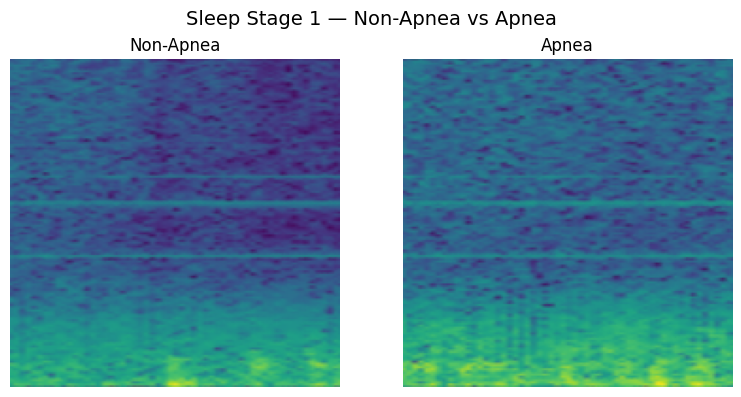

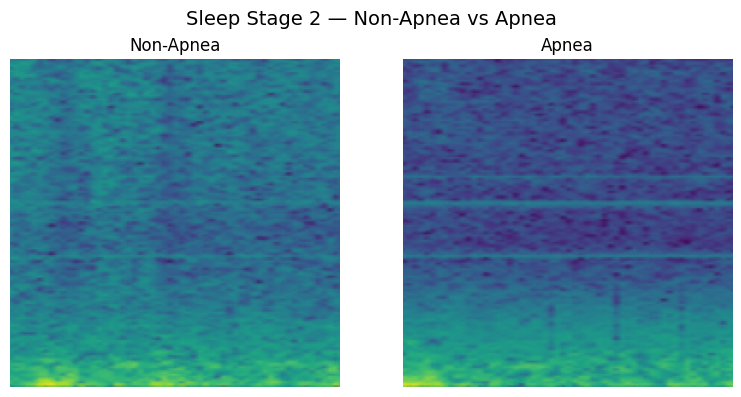

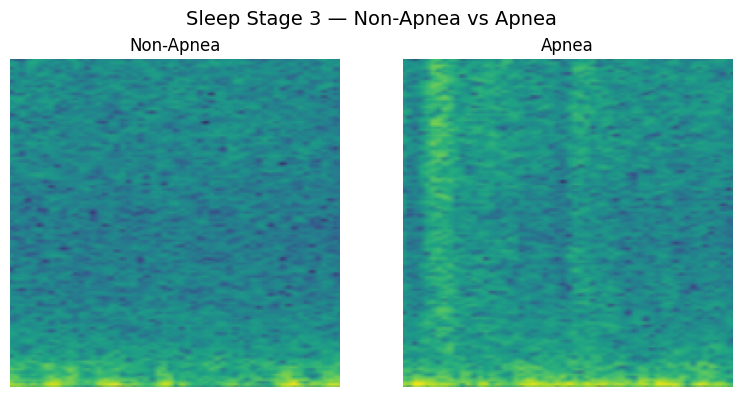

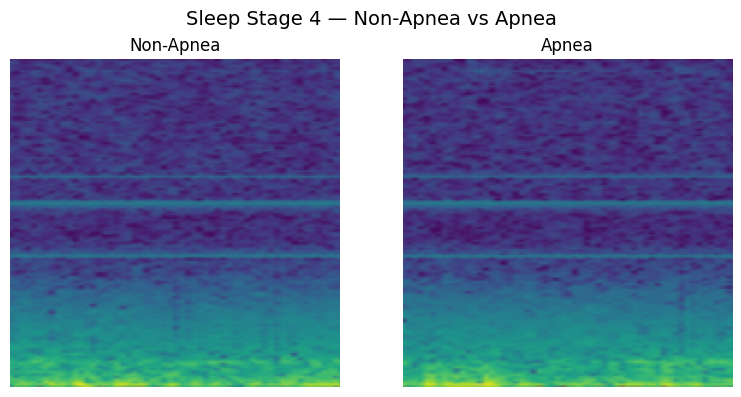

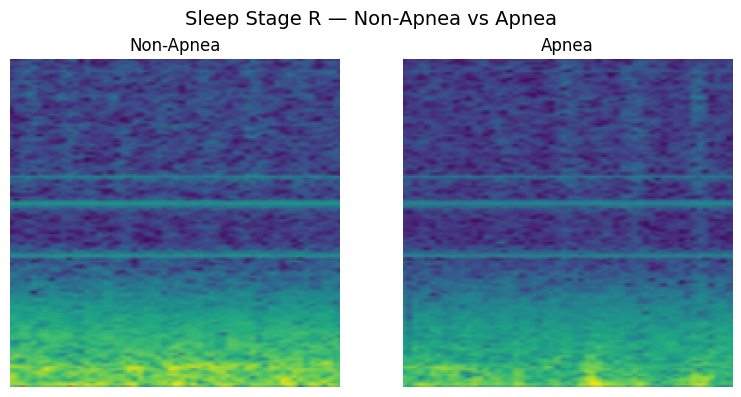

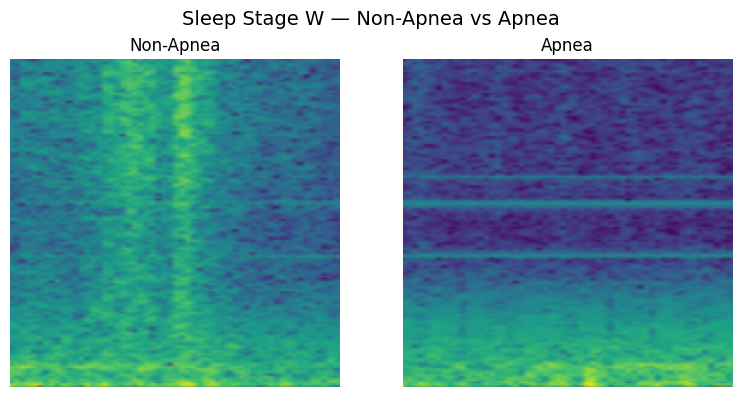

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

df = pd.read_csv('/kaggle/working/eeg_labels.csv')
img_dir = '/kaggle/working/eeg_spectrograms'
stages_to_plot = ['1', '2', '3', '4', 'R', 'W']

def load_img_or_blank(path):
    try:
        img = cv2.imread(path)
        if img is None:
            raise Exception("Invalid image")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except:
        return np.ones((227, 227, 3), dtype=np.uint8) * 255  # white image

for stage in stages_to_plot:
    sub = df[df['stage'] == stage]

    apnea = sub[sub['label'] == 1]
    non_apnea = sub[sub['label'] == 0]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"Sleep Stage {stage} — Non-Apnea vs Apnea", fontsize=14)

    # Load or blank image
    if len(non_apnea) > 0:
        img1 = load_img_or_blank(os.path.join(img_dir, non_apnea.iloc[0]['filename']))
        title1 = "Non-Apnea"
    else:
        img1 = np.ones((227, 227, 3), dtype=np.uint8) * 255
        title1 = "Missing Non-Apnea"

    if len(apnea) > 0:
        img2 = load_img_or_blank(os.path.join(img_dir, apnea.iloc[0]['filename']))
        title2 = "Apnea"
    else:
        img2 = np.ones((227, 227, 3), dtype=np.uint8) * 255
        title2 = "Missing Apnea"

    axes[0].imshow(img1)
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(img2)
    axes[1].set_title(title2)
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(f"/kaggle/working/fig_stage_{stage}_with_fallback.png", bbox_inches='tight')
    plt.show()


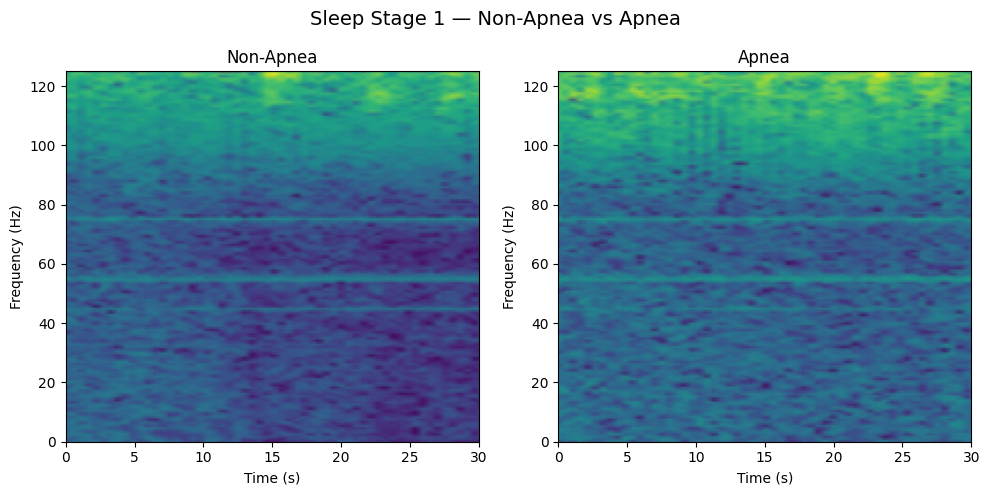

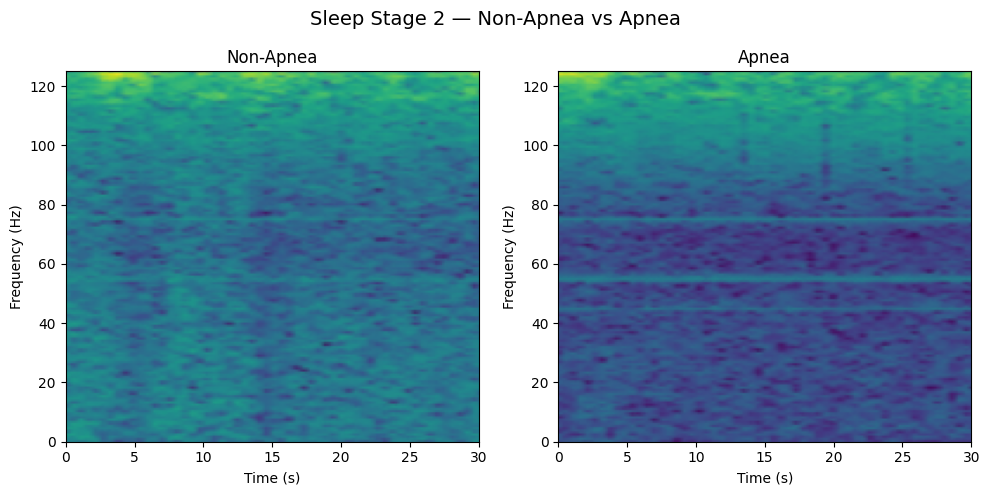

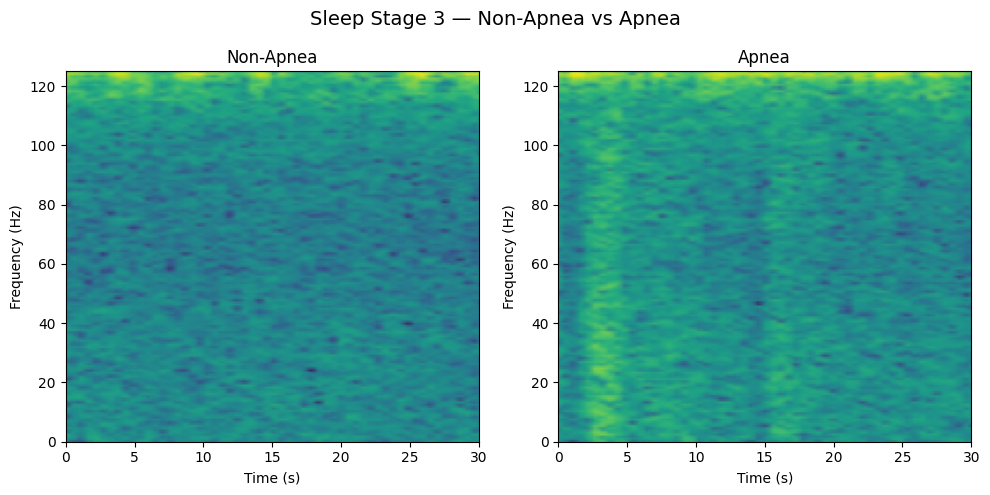

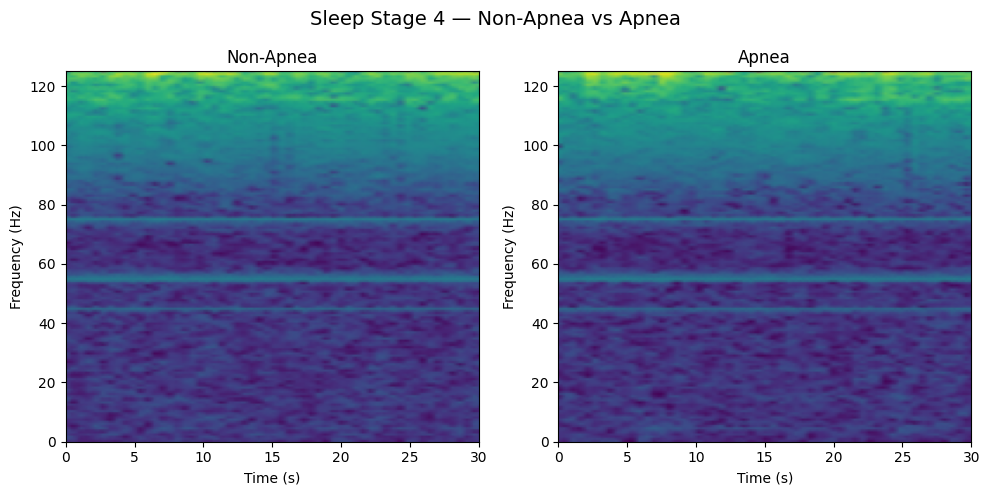

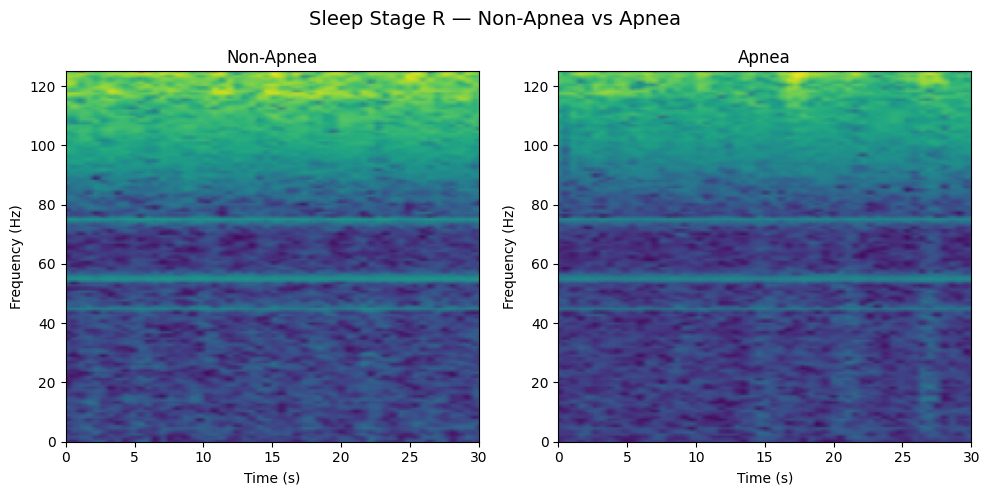

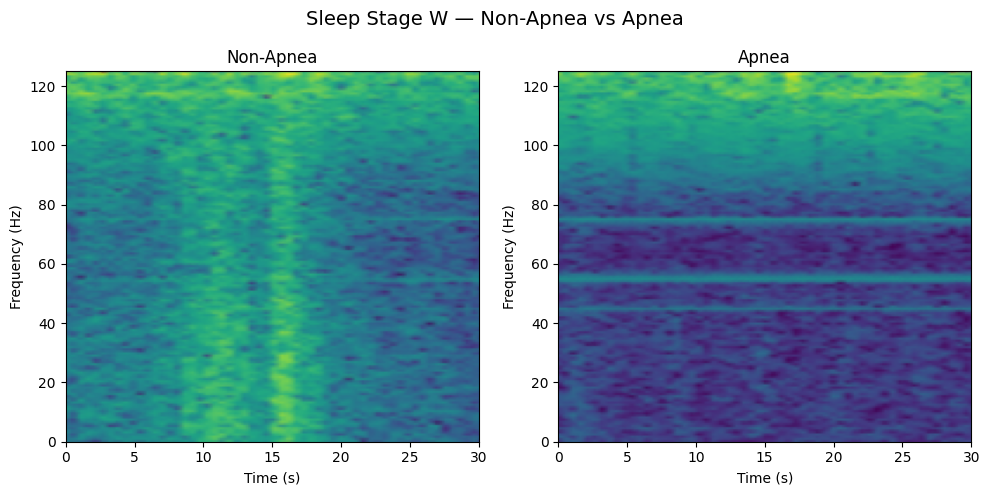

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

df = pd.read_csv('/kaggle/working/eeg_labels.csv')
img_dir = '/kaggle/working/eeg_spectrograms'
stages_to_plot = ['1', '2', '3', '4', 'R', 'W']

def load_img(path):
    img = cv2.imread(path)
    if img is None:
        return np.ones((227, 227, 3), dtype=np.uint8) * 255  # blank white
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for stage in stages_to_plot:
    sub = df[df['stage'] == stage]
    apnea = sub[sub['label'] == 1]
    non_apnea = sub[sub['label'] == 0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Sleep Stage {stage} — Non-Apnea vs Apnea", fontsize=14)

    for idx, (subset, label) in enumerate(zip([non_apnea, apnea], ["Non-Apnea", "Apnea"])):
        if len(subset) > 0:
            img = load_img(os.path.join(img_dir, subset.iloc[0]['filename']))
        else:
            img = np.ones((227, 227, 3), dtype=np.uint8) * 255  # fallback

        ax = axes[idx]
        ax.imshow(img, extent=[0, 30, 0, 125], origin='lower', aspect='auto')  # axis origin at bottom-left
        ax.set_title(label)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.savefig(f"/kaggle/working/fig_stage_{stage}_spectro_labeled.png", bbox_inches='tight')
    plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load full labeled spectrogram dataset
df = pd.read_csv('/kaggle/working/eeg_labels.csv')

# Define stage groups
trainval_stages = ['1', '2']
test_stages = ['3', '4', 'R', 'W']

# Filter
trainval_df = df[df['stage'].isin(trainval_stages)].reset_index(drop=True)
test_df     = df[df['stage'].isin(test_stages)].reset_index(drop=True)

# Split train/val stratified by label
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df['label'],
    random_state=42
)

# Save for later use
train_df.to_csv('/kaggle/working/train_stage12.csv', index=False)
val_df.to_csv('/kaggle/working/val_stage12.csv', index=False)
test_df.to_csv('/kaggle/working/test_stage34RW.csv', index=False)

# ✅ Summary
print(f"Train size: {len(train_df)}")
print(f"Val size:   {len(val_df)}")
print(f"Test size:  {len(test_df)}")


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

class EEGSpectrogramDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        label = int(row['label'])

        image = Image.open(img_path).convert('RGB')  # (3, H, W)
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# === Define EEG Dataset Class ===
class EEGDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        label = int(row['label'])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# === Transforms ===
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === Load CSVs ===
train_df = pd.read_csv('/kaggle/working/train_stage12.csv')
val_df   = pd.read_csv('/kaggle/working/val_stage12.csv')
test_df  = pd.read_csv('/kaggle/working/test_stage34RW.csv')

# === Set image directory ===
image_dir = '/kaggle/working/eeg_spectrograms'  # <- update this if needed

# === Create datasets ===
train_dataset = EEGDataset(train_df, image_dir=image_dir, transform=train_transform)
val_dataset   = EEGDataset(val_df, image_dir=image_dir, transform=val_transform)
test_dataset  = EEGDataset(test_df, image_dir=image_dir, transform=val_transform)

# === Create DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ApneaCNN(nn.Module):
    def __init__(self):
        super(ApneaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(0.3)

        self.fc1 = nn.Linear(28*28*128, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 114, 114]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 57, 57]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 28, 28]
        x = self.dropout_conv(x)

        x = x.view(-1, 28*28*128)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ApneaCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0

for epoch in range(10):
    model.train()
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)

    # === Validation ===
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pt')


In [ ]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Non-Apnea", "Apnea"]))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:  # or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())


In [ ]:
import numpy as np

# Raw confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot raw
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Apnea', 'Apnea'],
            yticklabels=['Non-Apnea', 'Apnea'])
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")

# Plot normalized
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=['Non-Apnea', 'Apnea'],
            yticklabels=['Non-Apnea', 'Apnea'])
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=["Non-Apnea", "Apnea"]))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

stage_acc = {}
for stage in sorted(df['stage'].dropna().unique()):
    stage_df = df[df['stage'] == stage].reset_index(drop=True)
    stage_dataset = EEGDataset(stage_df, image_dir=image_dir, transform=val_transform)
    stage_loader = DataLoader(stage_dataset, batch_size=32, shuffle=False)

    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in stage_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    acc = (np.array(y_true) == np.array(y_pred)).mean()
    stage_acc[stage] = acc

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=list(stage_acc.keys()), y=list(stage_acc.values()))
plt.title("Accuracy by Sleep Stage")
plt.ylabel("Accuracy")
plt.xlabel("Sleep Stage")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

for stage in sorted(df['stage'].dropna().unique()):
    stage_df = df[df['stage'] == stage].reset_index(drop=True)
    dataset = EEGDataset(stage_df, image_dir=image_dir, transform=val_transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", 
                xticklabels=["Non-Apnea", "Apnea"],
                yticklabels=["Non-Apnea", "Apnea"])
    plt.title(f"Confusion Matrix - Stage {stage}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

def get_probs(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    y_true, y_score = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            y_score.extend(out[:, 1].cpu().numpy())  # Prob of Apnea
            y_true.extend(y.numpy())
    return np.array(y_true), np.array(y_score)

# Plot overall
full_dataset = EEGDataset(df, image_dir=image_dir, transform=val_transform)
yt, ys = get_probs(full_dataset)
fpr, tpr, _ = roc_curve(yt, ys)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All Stages")
plt.legend()
plt.grid(True)
plt.show()

# Plot per stage
plt.figure(figsize=(8, 6))
for stage in sorted(df['stage'].dropna().unique()):
    sub_df = df[df['stage'] == stage].reset_index(drop=True)
    y_true, y_score = get_probs(EEGDataset(sub_df, image_dir=image_dir, transform=val_transform))
    if len(np.unique(y_true)) < 2:
        continue  # skip if only one class
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Stage {stage} (AUC={auc_val:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves by Sleep Stage")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score

summary = []
for stage in sorted(df['stage'].dropna().unique()):
    stage_df = df[df['stage'] == stage].reset_index(drop=True)
    dataset = EEGDataset(stage_df, image_dir=image_dir, transform=val_transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    non_apnea_acc = ((np.array(y_true) == 0) & (np.array(y_pred) == 0)).sum() / (np.array(y_true) == 0).sum()
    apnea_acc = ((np.array(y_true) == 1) & (np.array(y_pred) == 1)).sum() / (np.array(y_true) == 1).sum()

    summary.append([stage, round(non_apnea_acc, 2), round(apnea_acc, 2), len(stage_df)])

import pandas as pd
summary_df = pd.DataFrame(summary, columns=["Stage", "Non-Apnea Acc", "Apnea Acc", "Total Samples"])
from IPython.display import display
display(summary_df)
